In [1]:
import logging
from argparse import ArgumentParser

import torch
import torch.nn.functional as F
# import wandb
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import trange

from experiments.data import INRDataset
from experiments.utils import (
    common_parser,
    count_parameters,
    get_device,
    set_logger,
    set_seed,
    str2bool,
)
from nn.models import DWSModelForClassification, MLPModelForClassification , DWSModel

from experiments.mnist.generate_data_splits import generate_splits
from experiments.mnist.compute_statistics import compute_stats

set_logger()

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.enabled = False

In [4]:
# generate_splits(data_path="notebooks/dataset/mnist-inrs", save_path="dataset")

In [5]:
# compute_stats(data_path="notebooks/dataset/mnist_splits.json", save_path="dataset", batch_size=1024)

## INR Dataset

We create INR Datasets and Dataloaders, and visualize some INRs (by reconstruction the images).



In [6]:
#Loading inr data we created while mnist training
import os
current_working_directory = os.getcwd()
print(current_working_directory)
path = current_working_directory + "/notebooks/dataset/mnist_splits.json"
statistics_path = current_working_directory + "/notebooks/dataset/statistics.pth"
normalize = True
augmentation = True

batch_size = 32
num_workers = 1

/work/talisman/sgupta/DWSNets/equivariant-diffusion


/work/talisman/sgupta/DWSNets/equivariant-diffusion/experiments/data.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location="cpu")


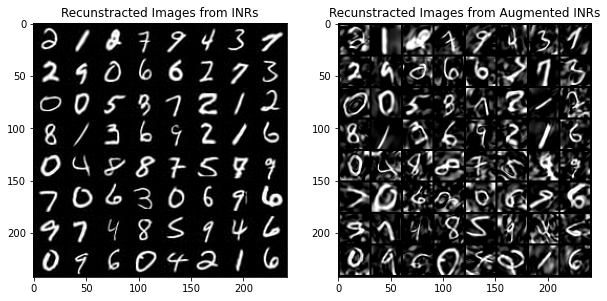

In [7]:
from torchvision.utils import save_image, make_grid
import torch

from experiments.data import INRImageDataset
from experiments.utils import set_seed
import matplotlib.pyplot as plt
dataset = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=False,
    split="train",
)

loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

dataset_aug = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=True,
    split="train",
)
loader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=64, shuffle=False)

batch = next(iter(loader))
batch_aug = next(iter(loader_aug))

fig, axs = plt.subplots(1, 2, figsize=(10,20)) 

axs[0].imshow(make_grid(batch.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[0].set_title('Recunstracted Images from INRs')

axs[1].imshow(make_grid(batch_aug.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[1].set_title('Recunstracted Images from Augmented INRs')
plt.show()

In [8]:
train_set = INRDataset(
        path=path,
        split="train",
        normalize=normalize,
        augmentation=augmentation,
        statistics_path=statistics_path,
    )

val_set = INRDataset(
    path=path,
    split="val",
    normalize=normalize,
    statistics_path=statistics_path,
)

test_set = INRDataset(
    path=path,
    split="test",
    normalize=normalize,
    statistics_path=statistics_path,
)

train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

/work/talisman/sgupta/DWSNets/equivariant-diffusion/experiments/data.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.stats = torch.load(statistics_path, map_locati

In [9]:
point = train_set.__getitem__(4)
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)
print(weight_shapes,bias_shapes)
# print(point.weights,point.biases,point.label)

(torch.Size([2, 32]), torch.Size([32, 32]), torch.Size([32, 1])) (torch.Size([32]), torch.Size([32]), torch.Size([1]))


/work/talisman/sgupta/DWSNets/equivariant-diffusion/experiments/data.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=lambda 

In [10]:
new_weight_shapes = (torch.Size([2, 8]), torch.Size([8, 8]), torch.Size([8, 1]))
new_bias_shapes = (torch.Size([8]), torch.Size([8]), torch.Size([1]))

In [11]:
from typing import Tuple
import torch
import torch.nn as nn
from nn.layers import BN, DWSLayer,InvariantLayer, Dropout, ReLU
from nn.layers.base import BaseLayer,GeneralSetLayer

class DWSEncoder(BaseLayer):
    def __init__(
       self,
        weight_shapes,
        bias_shapes,
        input_features,
        hidden_dims,
        downsample_dim,
        n_hidden=2,
        reduction="max",
        bias=True,
        n_fc_layers=1,
        num_heads=4,
        set_layer="sab",
        add_layer_skip=False,
        input_dim_downsample=None,
        dropout_rate=0.0,
        init_scale=1.,
        init_off_diag_scale_penalty=1.,
        bn=False,
        diagonal=False,
    ):
        super().__init__(
            in_features=input_features,
            out_features=hidden_dims,
            bias=bias,
            reduction=reduction,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
        )

        assert len(weight_shapes) > 2, "The implementation only supports networks with more than 2 layers."

        self.downsample_dim = downsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
        self.skip = self._get_mlp(
            in_features=input_features,
            out_features=input_features,
            bias=bias,
        )
        
        self.InitialLayer = DWSModel(
            weight_shapes= weight_shapes,
            bias_shapes=bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )
        
    def downsample_input_weights(self, inputs, downsample_dim):
        """Downsample the input weights to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first weight dimension [32,2,32,1] -> [32,2,8,1]
        inputs[0] = self._downsample_weight(inputs[0], dim=2, downsample_dim = downsample_dim)
        # Downsample second weight dimension [32,32,32,1] -> [32,8,8,1]
        inputs[1] = self._downsample_weight(inputs[1], dim=1, downsample_dim = downsample_dim)
        inputs[1] = self._downsample_weight(inputs[1], dim=2, downsample_dim = downsample_dim)

        # Downsample third weight dimension [32,32,1,1] -> [32,8,1,1]
        inputs[2] = self._downsample_weight(inputs[2], dim=1, downsample_dim = downsample_dim)

        return tuple(inputs)

    def downsample_input_biases(self, inputs, downsample_dim):
        """Downsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,32,1] -> [32,8,1]
        inputs[0] = self._downsample_bias(inputs[0], downsample_dim= downsample_dim)

        # Downsample second bias dimension [32,32,1] -> [32,8,1]
        inputs[1] = self._downsample_bias(inputs[1], downsample_dim = downsample_dim)

        return tuple(inputs)

    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        """Forward pass through the encoder."""
        weights_skip = [self.skip(x[0][0]), self.skip(x[0][1]), self.skip(x[0][2])]
        bias_skip = [self.skip(x[1][0]), self.skip(x[1][1]), self.skip(x[1][2])]
        x = self.InitialLayer(x)
        weights = self.downsample_input_weights(x[0], 24)
        biases = self.downsample_input_biases(x[1], 24)
        weights = self.downsample_input_weights(weights, 16)
        biases = self.downsample_input_biases(biases, 16)
        weights = self.downsample_input_weights(weights, self.downsample_dim)
        biases = self.downsample_input_biases(biases, self.downsample_dim)
        out = (weights, biases)
        return out, weights_skip, bias_skip

    def _downsample_weight(self, weight, dim,downsample_dim):
        d0 = weight.shape[dim]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features= downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)

    def _downsample_bias(self, bias, downsample_dim):
        d0 = bias.shape[1]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features=downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = bias.permute(0, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 1)

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return self.relu(x + residual)

class BiasResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.relu(x + residual)

In [13]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # For Weight Reconstruction
        self.deconv_weight_1 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            ResidualBlock(16),
            nn.ConvTranspose2d(16, 24, kernel_size=(1, 1)),
            ResidualBlock(24),
            nn.ConvTranspose2d(24, 32, kernel_size=(1, 1)),
        )
        self.deconv_weight_21 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            ResidualBlock(16),
            nn.ConvTranspose2d(16, 24, kernel_size=(1, 1)),
            ResidualBlock(24),
            nn.ConvTranspose2d(24, 32, kernel_size=(1, 1)),
        )
        self.deconv_weight_22 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            ResidualBlock(16),
            nn.ConvTranspose2d(16, 24, kernel_size=(1, 1)),
            ResidualBlock(24),
            nn.ConvTranspose2d(24, 32, kernel_size=(1, 1)),
        )
        self.deconv_weight_3 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            ResidualBlock(16),
            nn.ConvTranspose2d(16, 24, kernel_size=(1, 1)),
            ResidualBlock(24),
            nn.ConvTranspose2d(24, 32, kernel_size=(1, 1)),
        )

        # For Bias Reconstruction
        self.fc_bias_1 = nn.Sequential(
            nn.Linear(8, 16),
            BiasResidualBlock(16),
            nn.Linear(16, 24),
            BiasResidualBlock(24),
            nn.Linear(24, 32),
        )
        self.fc_bias_2 = nn.Sequential(
            nn.Linear(8, 16),
            BiasResidualBlock(16),
            nn.Linear(16, 24),
            BiasResidualBlock(24),
            nn.Linear(24, 32),
        )
        self.fc_bias_3 = nn.Sequential(
            nn.Linear(1, 1),
            BiasResidualBlock(1),
            nn.Linear(1, 1),
        )

    def forward(self, x, weights_skip, bias_skip):
        # Decode weight tensors
        weight_space = x[0]
        bias_space = x[1]
        new_weight_space = []
        new_weight_space.append(self.deconv_weight_1(weight_space[0].permute(0,2,1,3)).permute(0,2,1,3))
        weight2_intermediate = self.deconv_weight_21(weight_space[1])
        new_weight_space.append(self.deconv_weight_22(weight2_intermediate.permute(0,2,1,3)).permute(0,2,1,3))
        new_weight_space.append(self.deconv_weight_3(weight_space[2]))

        new_bias_space = []
        # Decode bias tensors
        new_bias_space.append(self.fc_bias_1(bias_space[0].squeeze(-1)).view(-1, 32, 1))
        new_bias_space.append(self.fc_bias_2(bias_space[1].squeeze(-1)).view(-1, 32, 1))
        new_bias_space.append(self.fc_bias_3(bias_space[2].squeeze(-1)).view(-1, 1, 1))
        
        new_weight_space = (new_weight_space[0] + weights_skip[0], new_weight_space[1] + weights_skip[1], new_weight_space[2] + weights_skip[2])
        new_bias_space = (new_bias_space[0] + bias_skip[0], new_bias_space[1] + bias_skip[1], new_bias_space[2] + bias_skip[2])
        
        return (tuple(new_weight_space), tuple(new_bias_space))

In [14]:
# Our AutoEncoder using DWSModel
import numpy as np
class AutoEncoder(nn.Module):
    def __init__(self,
            input_features,
            weight_shapes,
            bias_shapes,
            hidden_dims,
            downsample_dim,
            n_hidden=2,
            reduction = "attn",
            input_dim_downsample=None,
            bn = False,
    ):
        super().__init__()
        self.encoder = DWSEncoder(weight_shapes=weight_shapes,
                                bias_shapes=bias_shapes,
                                input_features=input_features,
                                hidden_dims=hidden_dims,
                                downsample_dim = downsample_dim,
                                n_hidden=n_hidden,
                                reduction= reduction,
                                bn=bn).to(device)
        self.decoder = Decoder().to(device)
        
    def forward(self,inputs):
        encoded_data, weights_skip, bias_skip = self.encoder(inputs)
        output = self.decoder(encoded_data, weights_skip, bias_skip)
        return output

Training Autoencoder

In [15]:
# Custom loss function for tuples of tensors because our AutoEncoder gets tensors as output (not sure if this is the correct approach)
class TupleLoss(nn.Module):
    def __init__(self):
        super(TupleLoss, self).__init__()
        self.base_loss = nn.MSELoss()

    def forward(self, output, target):
        weights1, biases1 = output
        weights2, biases2 = target
        weight_loss = [self.base_loss(w1, w2) for w1, w2 in zip(weights1, weights2)]
        weight_loss = torch.mean(torch.stack(weight_loss))
        
        bias_loss = [self.base_loss(b1, b2) for b1, b2 in zip(biases1, biases2)]
        bias_loss = torch.mean(torch.stack(bias_loss))
                
        total_loss = 0.5*weight_loss + 0.5*bias_loss
        
        return total_loss

In [16]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    total = 0.0
    criterion =  TupleLoss()
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)
        loss += criterion(out, inputs)
        total += 1

    model.train()
    avg_loss = loss / total

    return avg_loss

In [17]:
def adjust_learning_rate(optimizer, epoch, initial_lr, lr_factor=0.1):
    """Reduces learning rate after 25 epochs, then after every 50 epochs."""
    if epoch == 25 or (epoch > 25 and (epoch - 25) % 50 == 0):
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_factor
        print(f"Reduced learning rate at epoch {epoch} to {param_group['lr']}")
        return param_group['lr']
    return initial_lr

In [18]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_between_spaces(t1, t2):
    t1_flat = t1.flatten()
    t2_flat = t2.flatten()
    return cosine_similarity([t1_flat], [t2_flat])[0][0]

def flatten_and_concatenate(tensors):
    flattened = [t.view(t.size(0), -1).detach().cpu() for t in tensors] 
    return torch.cat(flattened, dim=1)

def apply_tsne(data, perplexity=30, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    return tsne.fit_transform(data.numpy())

def plot_tsne(tsne_result, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()
    
def plot_combined_tsne(tsne_weights1, tsne_weights2, tsne_biases1, tsne_biases2):
    plt.figure(figsize=(10, 8))
    
    # Plot t-SNE of original weights
    plt.scatter(tsne_weights1[:, 0], tsne_weights1[:, 1], alpha=0.5, label='Original Weights', c='blue')
    
    # Plot t-SNE of latent weights
    plt.scatter(tsne_weights2[:, 0], tsne_weights2[:, 1], alpha=0.5, label='Latent Weights', c='green')
    
    plt.title('t-SNE of Weights (Original and Latent Spaces)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.show()
    
    plt.clf()
    
    plt.figure(figsize=(10, 8))  
   # Plot t-SNE of original biases
    plt.scatter(tsne_biases1[:, 0], tsne_biases1[:, 1], alpha=0.5, label='Original Biases', c='red')
    
    # Plot t-SNE of latent biases
    plt.scatter(tsne_biases2[:, 0], tsne_biases2[:, 1], alpha=0.5, label='Latent Biases', c='purple')
    
    plt.title('t-SNE of Biases (Original and Latent Spaces)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.show()
    
def compute_procrustes(t1, t2):
    # Assuming t1 and t2 are the 2D t-SNE embeddings of the original and latent spaces
    mtx1, mtx2, disparity = procrustes(t1, t2)
    return disparity  # Lower disparity means higher similarity

def analyze_equivariance(inputs, latent_space):
   
    # Assuming you have these tensors on CUDA
    weights1 = inputs[0]
    biases1 = inputs[1]

    weights2 = latent_space[0]
    biases2 = latent_space[1]

    # Flatten and concatenate weights and biases
    flattened_weights1 = flatten_and_concatenate(weights1)
    flattened_biases1 = flatten_and_concatenate(biases1)
    flattened_weights2 = flatten_and_concatenate(weights2)
    flattened_biases2 = flatten_and_concatenate(biases2)
    

    # Apply t-SNE
    tsne_weights1 = apply_tsne(flattened_weights1)
    tsne_biases1 = apply_tsne(flattened_biases1)
    tsne_weights2 = apply_tsne(flattened_weights2)
    tsne_biases2 = apply_tsne(flattened_biases2)
    
    plot_combined_tsne(tsne_weights1, tsne_weights2, tsne_biases1, tsne_biases2)
    
    original_distance = np.mean(np.linalg.norm(tsne_weights1[:, None, :] - tsne_weights1[None, :, :], axis=2))
    latent_distance = np.mean(np.linalg.norm(tsne_weights2[:, None, :] - tsne_weights2[None, :, :], axis=2))

    print(f'Average distance in original space for weights: {original_distance}')
    print(f'Average distance in latent space for weights: {latent_distance}')
    
    original_distance = np.mean(np.linalg.norm(tsne_biases1[:, None, :] - tsne_biases1[None, :, :], axis=2))
    latent_distance = np.mean(np.linalg.norm(tsne_biases2[:, None, :] - tsne_biases2[None, :, :], axis=2))

    print(f'Average distance in original space for biases: {original_distance}')
    print(f'Average distance in latent space for biases: {latent_distance}')


#     # Plot results
#     plot_tsne(tsne_weights1, 't-SNE of Weights (Original Space)')
#     plot_tsne(tsne_weights2, 't-SNE of Weights (Latent Space)')
#     plot_tsne(tsne_biases1, 't-SNE of Biases (Original Space)')
#     plot_tsne(tsne_biases2, 't-SNE of Biases (Latent Space)')
    
    # Compute and compare
#     disparity = compute_procrustes(tsne_weights1, tsne_weights2)
#     disparity2 = compute_procrustes(tsne_biases1, tsne_biases2)
#     print(f"Procrustes Disparity between weights and biases: {disparity} , {disparity2}")
    
#     similarity = cosine_similarity_between_spaces(tsne_weights1, tsne_weights2)
#     similarity2 = cosine_similarity_between_spaces(tsne_biases1, tsne_biases2)
#     print(f"Cosine Similarity between weights and biases: {similarity}, {similarity2}")    

In [19]:
import logging
import torch
from tqdm import trange
        
def train_model(model):
    learning_rate = 1e-3
    num_epochs = 1000
    criterion = TupleLoss() 
    epoch_iter = trange(num_epochs)
    epoch_loss = -1
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


    for epoch in epoch_iter:
        total_loss = 0
        counter = 0
        
        for i, batch in enumerate(train_loader):
            model.train() 
            optimizer.zero_grad()

            batch = batch.to(device)
            inputs = (batch.weights, batch.biases)
            out = model(inputs)
#             analyze_equivariance(inputs, out)
            
            loss = criterion(out, inputs)
            loss.backward()  
            optimizer.step() 

            total_loss += loss.item()
            counter += 1

            epoch_iter.set_description(
                f"[{epoch} {i+1}], train loss: {loss.item():.3f}, epoch loss: {epoch_loss:.3f}"
            )

        epoch_loss = total_loss / counter

        scheduler.step(epoch_loss)

        # Save model and evaluate every 25 epochs
        if (epoch + 1) % 25 == 0:
            model_path = f"Outputs/model_epoch_withSkip_{epoch+1}_loss_{epoch_loss:.4f}.pth"
            torch.save(model.state_dict(), model_path)
            print(f"Model saved to {model_path}")
            print(evaluate(model, test_loader))

    print("Training complete!")


In [ ]:
# #Model with DWS DownSample Layers
model = AutoEncoder(
    input_features=1,
    weight_shapes = weight_shapes, 
    bias_shapes = bias_shapes,
    downsample_dim = 8,
    hidden_dims=32,
    reduction = "max",
    n_hidden=4,
    bn=True,
).to(device)

# model = DWSEncoder(weight_shapes=weight_shapes,
#                                 bias_shapes=bias_shapes,
#                                 input_features=1,
#                                 hidden_dims=32,
#                                 downsample_dim = 8,
#                                 n_hidden=4,
#                                 reduction= "max",
#                                 bn=True).to(device)

for name, param in model.named_parameters():
    if param.dim() >= 2:  # Initialize weights (only for tensors with 2 or more dimensions)
        # Initialize convolutional layer weights using Kaiming normal initialization
        if 'conv' in name and 'weight' in name:
            nn.init.kaiming_normal_(param)
        # Initialize linear layer weights using Xavier uniform initialization
        elif 'fc' in name and 'weight' in name:
            nn.init.xavier_uniform_(param)
                    
model.encoder.load_state_dict(torch.load("Outputs/model_encoder.pth"), strict=False)
for param in model.encoder.parameters():
    param.requires_grad = False
# model.load_state_dict(torch.load("Outputs/model_epoch_25_loss_0.8658.pth"))
train_model(model)

<ipython-input-20-d00690f53a7b>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.encoder.load_state_dict(torch.load("Outputs/model_encoder.pth"), strict=False)
[2 155

In [ ]:
1.516